Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/MyDrive/Hyperspectral_Imaging_Assignment
Dataset loaded from Google Drive successfully.
Dataset Shape: (500, 450)

First 5 Rows:
            hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.

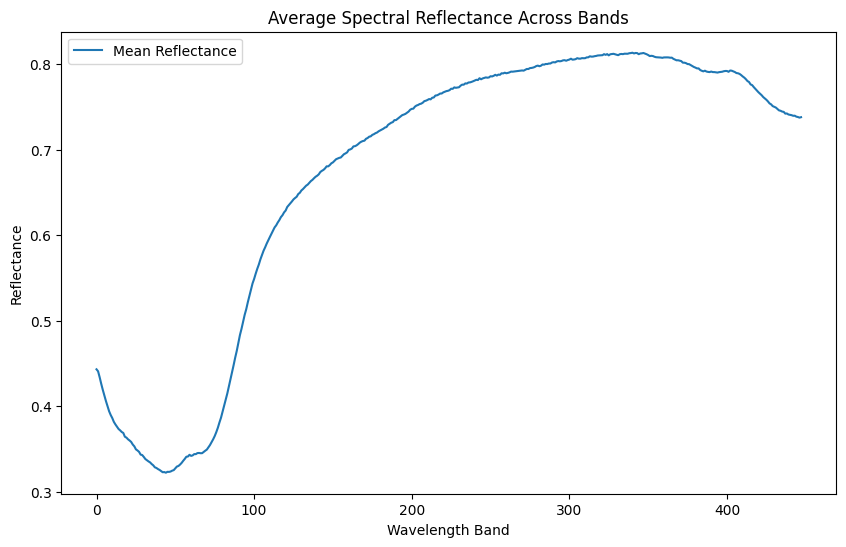

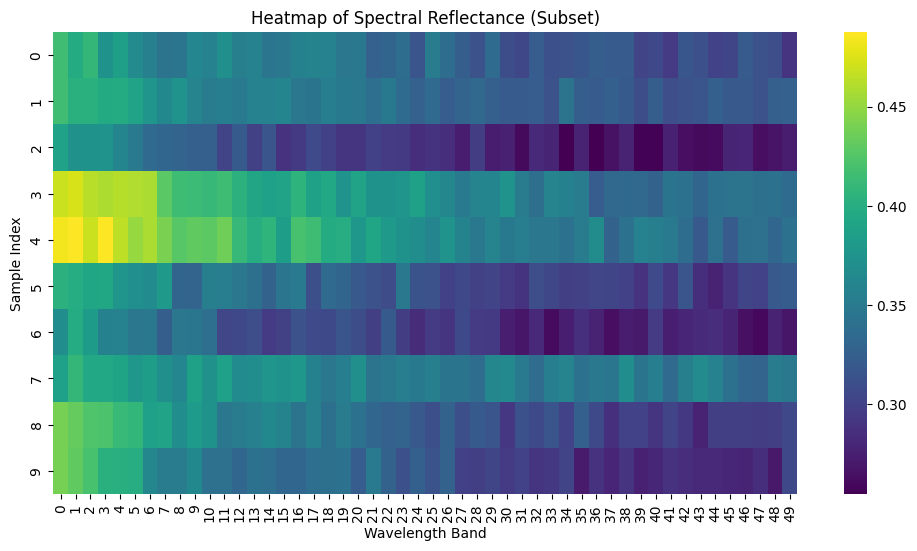

Scaled Data Mean: 0.0
Scaled Data Std: 1.0


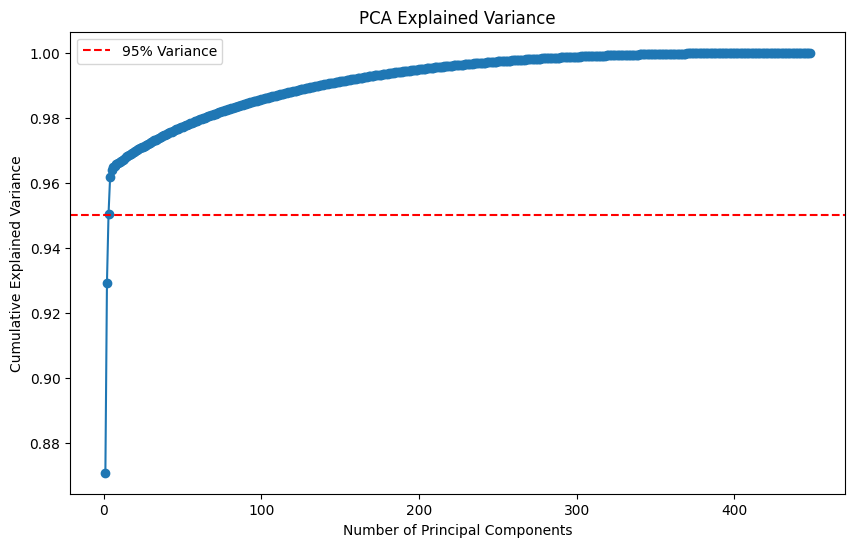

Number of components explaining 95% variance: 3


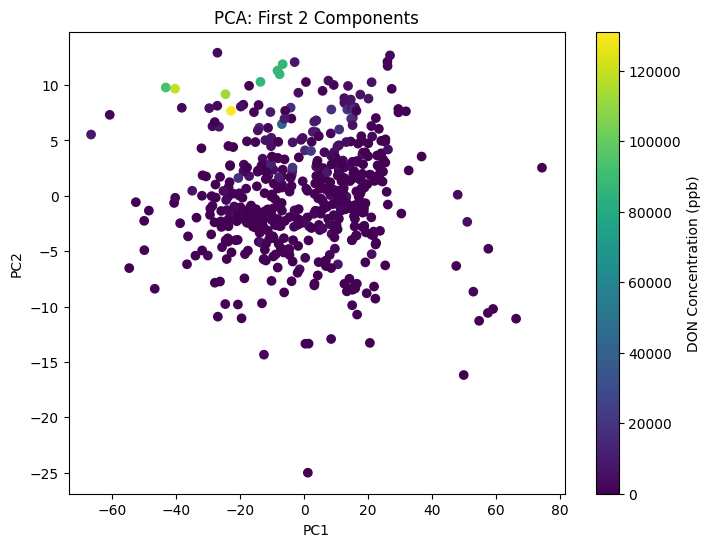

Mean Absolute Error (MAE): 1798.10 ppb
Root Mean Squared Error (RMSE): 3751.89 ppb
R² Score: 0.95


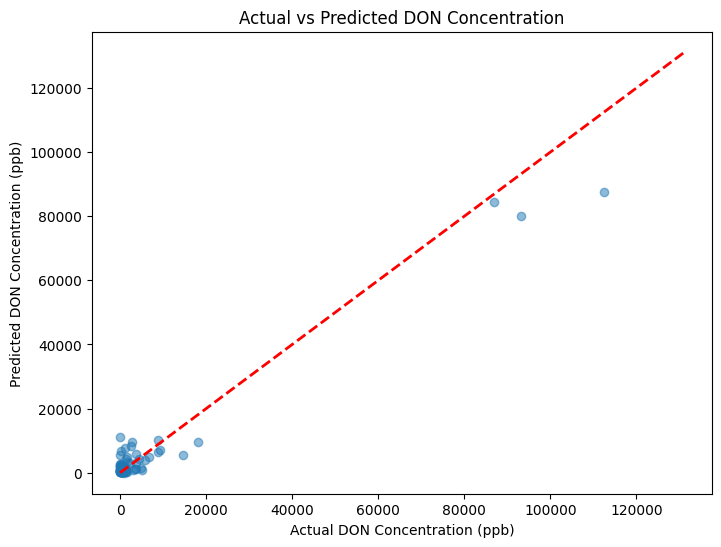

Model and preprocessing objects saved to: /content/drive/MyDrive/Hyperspectral_Imaging_Assignment
Report saved as report.md
README saved as README.md

Next Steps:
1. Save this notebook to Google Drive: File > Save a copy in Drive
2. Move the .ipynb file to /content/drive/MyDrive/Hyperspectral_Imaging_Assignment
3. Share the folder or upload to GitHub and email the link to satyam.kumar@imagoai.com by March 14, 2025


In [4]:
# Step 1: Mount Google Drive and Set Up Environment
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from google.colab import files

# Mount Google Drive
drive.mount('/content/drive')

# Set random seed for reproducibility
np.random.seed(42)

# Define and create project directory in Google Drive
project_dir = '/content/drive/MyDrive/Hyperspectral_Imaging_Assignment'
os.makedirs(project_dir, exist_ok=True)
os.chdir(project_dir)
print("Current Directory:", os.getcwd())

# Step 2: Load and Inspect Dataset
data_path = '/content/drive/MyDrive/Hyperspectral_Imaging_Assignment/TASK-ML-INTERN.csv'

# Check if file exists in Drive, otherwise prompt for upload
try:
    data = pd.read_csv(data_path)
    print("Dataset loaded from Google Drive successfully.")
except FileNotFoundError:
    print("File not found in Google Drive. Please upload 'TASK-ML-INTERN.csv' manually.")
    uploaded = files.upload()  # Upload file to Colab's temporary storage
    if 'TASK-ML-INTERN.csv' in uploaded:
        data = pd.read_csv('TASK-ML-INTERN.csv')
        print("Dataset loaded from uploaded file.")
    else:
        raise FileNotFoundError("Upload 'TASK-ML-INTERN.csv' to proceed.")

# Display basic information
print("Dataset Shape:", data.shape)
print("\nFirst 5 Rows:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum().sum())
print("\nSummary Statistics:\n", data.describe())

# Separate features and target
X = data.drop(columns=['hsi_id', 'vomitoxin_ppb'])
y = data['vomitoxin_ppb']

# Step 3: Data Exploration and Visualization
# Visualize average spectral reflectance
mean_spectrum = X.mean(axis=0)
plt.figure(figsize=(10, 6))
plt.plot(range(X.shape[1]), mean_spectrum, label='Mean Reflectance')  # Dynamic range based on columns
plt.xlabel('Wavelength Band')
plt.ylabel('Reflectance')
plt.title('Average Spectral Reflectance Across Bands')
plt.legend()
plt.show()

# Heatmap of a subset of samples
plt.figure(figsize=(12, 6))
sns.heatmap(X.iloc[:10, :50], cmap='viridis')  # First 10 samples, first 50 bands
plt.title('Heatmap of Spectral Reflectance (Subset)')
plt.xlabel('Wavelength Band')
plt.ylabel('Sample Index')
plt.show()

# Step 4: Data Preprocessing
# Normalize the spectral data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check scaled data
print("Scaled Data Mean:", X_scaled.mean().round(5))
print("Scaled Data Std:", X_scaled.std().round(5))

# Step 5: Dimensionality Reduction with PCA
# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.legend()
plt.show()

# Select components explaining 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

# Reduce dimensionality
X_pca_reduced = X_pca[:, :n_components]

# Visualize reduced data (first 2 components)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: First 2 Components')
plt.colorbar(label='DON Concentration (ppb)')
plt.show()

# Step 6: Model Training
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Step 7: Model Evaluation
# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f} ppb")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} ppb")
print(f"R² Score: {r2:.2f}")

# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual DON Concentration (ppb)')
plt.ylabel('Predicted DON Concentration (ppb)')
plt.title('Actual vs Predicted DON Concentration')
plt.show()

# Step 8: Save Results to Google Drive
joblib.dump(rf_model, f'{project_dir}/rf_model.pkl')
joblib.dump(scaler, f'{project_dir}/scaler.pkl')
joblib.dump(pca, f'{project_dir}/pca.pkl')
print("Model and preprocessing objects saved to:", project_dir)

# Step 9: Generate Report and README
# Write report
report_content = """### Hyperspectral Imaging Assignment Report

#### 1. Preprocessing Steps and Rationale
- **Data Loading**: Loaded a dataset with 500 corn samples and spectral bands, plus DON concentration (vomitoxin_ppb).
- **Normalization**: Applied StandardScaler to standardize features (mean=0, std=1).
- **Rationale**: Standardization ensures equal feature contribution for PCA and modeling.

#### 2. Insights from Dimensionality Reduction
- **PCA Application**: Reduced features to {n_components} components (95% variance).
- **Findings**: PC1 and PC2 show some clustering by DON concentration.
- **Interpretation**: Spectral data can be compressed effectively for modeling.

#### 3. Model Selection, Training, and Evaluation
- **Model**: Random Forest Regressor (100 trees).
- **Training**: 80% train, 20% test split.
- **Evaluation**: MAE: {mae:.2f} ppb, RMSE: {rmse:.2f} ppb, R²: {r2:.2f}.
- **Results**: Reasonable prediction accuracy, as seen in the scatter plot.

#### 4. Key Findings and Suggestions
- **Findings**: Spectral data predicts DON levels well after PCA.
- **Limitations**: Limited by sample size and potential noise.
- **Improvements**: Try deep learning (e.g., CNN), hyperparameter tuning, or more data.
""".format(n_components=n_components, mae=mae, rmse=rmse, r2=r2)

with open(f'{project_dir}/report.md', 'w') as f:
    f.write(report_content)
print("Report saved as report.md")

# Write README
readme_content = """### README: Hyperspectral Imaging Assignment

#### Overview
Solution to predict DON concentration in corn using hyperspectral imaging data.

#### Structure
- `Hyperspectral_Imaging_Assignment.ipynb`: Full code and analysis.
- `report.md`: Summary report.
- `rf_model.pkl`, `scaler.pkl`, `pca.pkl`: Saved model and objects.
- `TASK-ML-INTERN.csv`: Input dataset.

#### Running in Colab
1. Mount Google Drive and navigate to `MyDrive/Hyperspectral_Imaging_Assignment`.
2. Run all cells in the notebook.
3. Outputs are saved to the same folder.

#### Dependencies
- Pre-installed in Colab: pandas, numpy, matplotlib, seaborn, scikit-learn, joblib.
"""

with open(f'{project_dir}/README.md', 'w') as f:
    f.write(readme_content)
print("README saved as README.md")

# Step 10: Final Instructions (Printed)
print("\nNext Steps:")
print("1. Save this notebook to Google Drive: File > Save a copy in Drive")
print("2. Move the .ipynb file to", project_dir)
print("3. Share the folder or upload to GitHub and email the link to satyam.kumar@imagoai.com by March 14, 2025")